# CS769 Course Project

## Import Libraries


In [ ]:
import os
import pickle
import math
import string
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
from nltk import tokenize
from nltk.corpus import stopwords
from nltk import sent_tokenize
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import numpy as np
import datetime
import pandas as pd
! pip install datasets transformers[sentencepiece]
! pip install nltk rouge_score
from datasets import load_metric
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.3 MB/s 
     |████████████████████████████████| 4.7 MB 46.6 MB/s 
     |████████████████████████████████| 141 kB 48.8 MB/s 
     |████████████████████████████████| 212 kB 36.1 MB/s 
     |████████████████████████████████| 101 kB 8.4 MB/s 
     |████████████████████████████████| 596 kB 48.2 MB/s 
     |████████████████████████████████| 127 kB 50.3 MB/s 
     |████████████████████████████████| 6.6 MB 23.0 MB/s 
     |████████████████████████████████| 1.2 MB 44.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all

## Download Wikihow Dataset

In [ ]:
%cd content

[Errno 2] No such file or directory: 'content'
/content


In [ ]:
!gdown --id 1KynAxFuChkHeJSq6dXABIYb7aIehGrhK
!tar -xf wikihow.tar.gz
os.remove('/content/WikiHow-Dataset/articles/desktop.ini')
print("Total Number of articles in dataset:{}".format(len(os.listdir('/content/WikiHow-Dataset/articles'))))
%cd WikiHow-Dataset

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KynAxFuChkHeJSq6dXABIYb7aIehGrhK
To: /content/wikihow.tar.gz
100% 297M/297M [00:03<00:00, 92.6MB/s]
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
Total Number of articles in dataset:70190
/content/WikiHow-Dataset


##Make Train and Test files

In [ ]:
c_train = 1
train_files = []
with open('all_train.txt','r') as tr:
  with open('train_new.txt', 'w') as new_tr:
    for line in tr:
      if(os.path.exists('articles/'+ line.rstrip('\n') + '.txt')):
        new_tr.write(line)
        train_files.append('articles/'+ line.rstrip('\n') + '.txt')
        c_train += 1  
      if(c_train==5000):
        break; 
c_test = 1
test_files = []
with open('titles.txt','r') as tr:
  with open('test_new.txt', 'w') as new_tr:
    for line in tr:
      if(os.path.exists('articles/'+ line.rstrip('\n') + '.txt')):
        test_files.append('articles/'+ line.rstrip('\n') + '.txt')
        new_tr.write(line)
        c_test += 1
      if(c_test==1000):
          break; 
  
print("Total Number of files in Train: {} and in Test: {}".format(c_train, c_test))

Total Number of files in Train: 5000 and in Test: 1000


##Summerization


In [ ]:
all_summ = []
all_art = []
i = 1
for file in test_files:
  summ = ''
  art = ''
  with open(file,'r') as txt:
    # print('reading file: {}'.format(i))
    for line in txt:
      if line == '@summary\n':
        line = next(txt)
        summ = summ + line
      elif line == '@article\n':
        line = next(txt)
        art = art+ line
      else:
        art = art+ line
    all_summ.append(summ.replace('\n', ' '))
    all_art.append(art)
  i +=1
  # break
print(len(all_art), len(all_summ))


999 999


####Cosine Similarity

In [ ]:
def get_cosine_sim_matrix(tf_idf):
    def fCosine(u, v):
        uData, vData = u.data, v.data
        denominator = math.sqrt(np.sum(uData ** 2) * np.sum(vData ** 2))
        uCol, vCol = u.indices, v.indices
        uI = uData[np.in1d(uCol, vCol)]
        vI = vData[np.in1d(vCol, uCol)]
        if denominator == 0:
            return 0
        return np.dot(uI, vI) / denominator

    n = tf_idf.shape[0]
    arr = np.zeros((n,n), dtype=np.float64)

    for i in range(n):
        for j in range(n):
            arr[i, j] = 1 if i == j else fCosine(tf_idf[i, :], tf_idf[j, :])
        # print(i)
    return arr

### Clustering


In [ ]:
def clustering(tf_idf, n):
    if(int(tf_idf.shape[0]*n) == 0):
      m = 1
    else:
      m = int(tf_idf.shape[0]*n)
    kmeans = KMeans(init='k-means++', verbose=0, n_clusters=m, random_state=1, n_init=10)
    kmeans.fit_transform(tf_idf)
    cluster_idxs = kmeans.labels_
    return cluster_idxs

###Hyperparameters

In [ ]:
import sys
params = dict()
params['k'] = 0.2 #Percentage of document as cluster
params['b'] = sys.getsizeof(summ) # Budget in byts
params['r'] = 0.1 # scaling factor
params['ld'] = 0.15 # Lambda
params['a'] = 6 # Alpha
params['L'] = True # For Coverage
params['R'] = True # For Diversity

### Similarity and TF-IDF

In [ ]:
docs_all = []

for art in all_art:
  sentences = sent_tokenize(art.replace('\n', ' '))
  total_documents = len(sentences)
  # print(summ)
  transformer = TfidfTransformer(sublinear_tf=True)
  stemmer = PorterStemmer()
  translator = str.maketrans('', '', string.punctuation)
  tokenizer = lambda text: [stemmer.stem(token.lower()) for token in tokenize.word_tokenize(text.translate(translator))]
  vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=tokenizer, stop_words='english')
  tfidf = transformer.fit_transform(vectorizer.fit_transform(sentences))
  sim_matrix = get_cosine_sim_matrix(tfidf)
  docs = dict()
  docs['sents'] = sentences
  docs['tf_idf'] = tfidf
  # print(tfidf.shape[0])
  docs['cluster_idxs'] = clustering(tfidf, params['k'])
  docs['sim_matrix'] = sim_matrix
  precompute = dict()
  U = list(range(len(docs['sents'])))
  for j in U:
    precompute[j] = math.fsum([docs['sim_matrix'][i,j] for i in U])
  docs['precompute'] = precompute
  docs_all.append(docs)


### Greedy algorithm and Submodular Functions


In [ ]:
def arg_max_greedy(docs, params):

    def coverage(S):
        # print(X) 
        if params['a'] == 1:
            return math.fsum(
                [math.fsum([docs['sim_matrix'][i, j] for i in S]) for j in X]
            )
        return math.fsum(
            [
                min(
                    (
                        math.fsum([docs['sim_matrix'][i, j] for j in S]),
                        params['a'] / len(docs['precompute']) * docs['precompute'][i]
                    )
                ) for i in X

                # min((
                #     math.fsum([docs['sim_matrix'][i, j] for i in X]),
                #     params['a']/len(docs['precompute']) * docs['precompute'][j]))
                # for j in S
            ]
        )

    def cost(S):
        return sum([len(sents[s]) for s in S])

    def diversity(S):
        return math.fsum(
            [
                math.sqrt(math.fsum(
                    [1/len(X) * docs['precompute'][j] for j in S if docs['cluster_idxs'][j] == kc]
                )
            ) for kc in range(int(params['k'] * docs['tf_idf'].shape[0]))]
        )

    def F(S):
        result = 0.0
        # print(params['ld'])
        if len(S) == 0:
            return result
        if params['L']:
            result += params['ld'] * coverage(S)
        if params['R']:
            result += (1 - params['ld']) * diversity(S)
        return result

    sents = docs['sents']
    X = list(range(len(docs['sents'])))
    G = []
    U = X[:]

    while len(U) > 0:
        max_k = float('-inf')
        k = None
        idx = None
        for l in range(len(U)):
            temp = (F(G + [U[l]]) - F(G)) / math.pow(cost([U[l]]), params['r'])
            if temp >= max_k:
                max_k = temp
                k = U[l]
                idx = l
        if cost(G + [k]) <= params['b'] and max_k > 0:
            G = G + [k]
        del U[idx]
        smallest = float('inf')
        for l in range(len(U)):
            small = cost([U[l]])
            if small < smallest:
                smallest = small
        if cost(G) + smallest > params['b']:
            break
    max_v = float('-inf')
    v_star = None
    for v in range(len(X)):
        if cost([X[v]]) <= params['b']:
            temp = F([X[v]])
            if temp >= max_v:
                max_v = temp
                v_star = X[v]
    if F([v_star]) > F(G):
        return [v_star]
    else:
        return G


### Summarize with Coverage and Diversity

In [ ]:
pred_summ_all = []
l = 1
for (docs,summ) in zip(docs_all, all_summ):
  summaries = ''
  if(len(docs['sents'])>4):
    params['b'] = sys.getsizeof(summ)
    X = arg_max_greedy(docs, params)
    for i in X:
      summaries +=  docs['sents'][i]
    pred_summ_all.append(summaries)
    # print('predicted summary for {}/{} documents'.format(l,999))
  else:
    pred_summ_all.append(summaries)
    l +=1
print(len(pred_summ_all))


999


###Calculate Rouge

In [ ]:
rouge = load_metric("rouge")
rouge.compute(predictions=pred_summ_all, references=all_summ)

{'rouge1': AggregateScore(low=Score(precision=0.22621312615779474, recall=0.32845925260806624, fmeasure=0.26271427397122865), mid=Score(precision=0.23258720184926618, recall=0.3375808019796699, fmeasure=0.2696202796955574), high=Score(precision=0.23918879826175685, recall=0.34634275844530366, fmeasure=0.27646531391814694)),
 'rouge2': AggregateScore(low=Score(precision=0.05428222027860588, recall=0.0810044457769194, fmeasure=0.06363892158228547), mid=Score(precision=0.05774311482895279, recall=0.08597755880651244, fmeasure=0.06743199133627792), high=Score(precision=0.06088702095382503, recall=0.09076100066387048, fmeasure=0.07107143601945601)),
 'rougeL': AggregateScore(low=Score(precision=0.134048086622795, recall=0.19750514163959987, fmeasure=0.15668195413274003), mid=Score(precision=0.13724574625769626, recall=0.2025602257867556, fmeasure=0.16022607832479255), high=Score(precision=0.14079142235963793, recall=0.20848708523777135, fmeasure=0.1642156142873292)),
 'rougeLsum': Aggregate

### Summarize with Only Coverage

In [ ]:
pred_summ_all = []
l = 1
params['R'] = False
for (docs,summ) in zip(docs_all, all_summ):
  summaries = ''
  if(len(docs['sents'])>4):
    params['b'] = sys.getsizeof(summ)
    X = arg_max_greedy(docs, params)
    for i in X:
      summaries +=  docs['sents'][i]
    pred_summ_all.append(summaries)
    # print('predicted summary for {}/{} documents'.format(l,999))
  else:
    pred_summ_all.append(summaries)
    l +=1
print(len(pred_summ_all))


999


###Calculate Rouge

In [ ]:
rouge = load_metric("rouge")
rouge.compute(predictions=pred_summ_all, references=all_summ)

{'rouge1': AggregateScore(low=Score(precision=0.22077229256562822, recall=0.34155040671169684, fmeasure=0.2588916278409677), mid=Score(precision=0.2274828563113386, recall=0.35159202273776713, fmeasure=0.26552346809116356), high=Score(precision=0.23447637432730026, recall=0.3607400768592313, fmeasure=0.272220777039945)),
 'rouge2': AggregateScore(low=Score(precision=0.05322211373895724, recall=0.08627232372817724, fmeasure=0.06300887480920375), mid=Score(precision=0.056669914059520723, recall=0.09159764227739658, fmeasure=0.06687978623420777), high=Score(precision=0.05984307168084382, recall=0.0966516964871388, fmeasure=0.07063697273633773)),
 'rougeL': AggregateScore(low=Score(precision=0.13131578346705017, recall=0.20641504526778284, fmeasure=0.15515333913238413), mid=Score(precision=0.13485947760868594, recall=0.21229585036669613, fmeasure=0.1586844339233437), high=Score(precision=0.13864165355174365, recall=0.2191175077336632, fmeasure=0.16276589457633434)),
 'rougeLsum': Aggregate

### Summarize with only Diversity

In [ ]:
pred_summ_all = []
l = 1
params['L'] = False
params['R'] = True
for (docs,summ) in zip(docs_all, all_summ):
  summaries = ''
  if(len(docs['sents'])>4):
    params['b'] = sys.getsizeof(summ)
    X = arg_max_greedy(docs, params)
    for i in X:
      summaries +=  docs['sents'][i]
    pred_summ_all.append(summaries)
    # print('predicted summary for {}/{} documents'.format(l,999))
  else:
    pred_summ_all.append(summaries)
    l +=1
print(len(pred_summ_all))


999


###Calculate Rouge

In [ ]:
rouge = load_metric("rouge")
rouge.compute(predictions=pred_summ_all, references=all_summ)

{'rouge1': AggregateScore(low=Score(precision=0.2164360732212753, recall=0.3377182739802211, fmeasure=0.2541908990800301), mid=Score(precision=0.223050122599169, recall=0.3479629469193951, fmeasure=0.2608711557547798), high=Score(precision=0.2296839702933281, recall=0.3570621903589721, fmeasure=0.2673283991103162)),
 'rouge2': AggregateScore(low=Score(precision=0.0528865519082611, recall=0.08713210065694248, fmeasure=0.06287553261987948), mid=Score(precision=0.05632378522217055, recall=0.09290281965817046, fmeasure=0.06677363380766098), high=Score(precision=0.05935004312925809, recall=0.0980550049501087, fmeasure=0.07031613019503918)),
 'rougeL': AggregateScore(low=Score(precision=0.12958615502643686, recall=0.20516134679822268, fmeasure=0.15310484547840472), mid=Score(precision=0.13321704137575374, recall=0.21106033020120624, fmeasure=0.15689256847539457), high=Score(precision=0.1368966979381741, recall=0.21786880373117454, fmeasure=0.16075346192797396)),
 'rougeLsum': AggregateScore(

###Experiment with Value of $\lambda$



In [ ]:
summ_lam = dict()
# l = 1
params['L'] = True
params['R'] = True
for t in range(11):
  params['ld'] = t/10
  print('Finding summary with lambda = {}'. format(params['ld']))
  pred_summ_all = []
  for (docs,summ) in zip(docs_all, all_summ):
    summaries = ''
    if(len(docs['sents'])>4):
      params['b'] = sys.getsizeof(summ)
      X = arg_max_greedy(docs, params)
      for i in X:
        summaries +=  docs['sents'][i]
      pred_summ_all.append(summaries)
      # print('predicted summary for {}/{} documents'.format(l,999))
    else:
      pred_summ_all.append(summaries)
      # l +=1
  summ_lam[t/10] = pred_summ_all



Finding summary with lambda = 0.0
Finding summary with lambda = 0.1
Finding summary with lambda = 0.2
Finding summary with lambda = 0.3
Finding summary with lambda = 0.4
Finding summary with lambda = 0.5
Finding summary with lambda = 0.6
Finding summary with lambda = 0.7
Finding summary with lambda = 0.8
Finding summary with lambda = 0.9
Finding summary with lambda = 1.0


###Calculate Rouge

In [ ]:
r = dict()
for t in range(11):
  pred_sum_all = summ_lam[t/10]
  # print(pred_sum_all)
  print('Rouge Score with lambda = {}'.format(t/10))
  # print(pred_sum_all)
  rouge = load_metric("rouge")
  r[t/10] = rouge.compute(predictions=summ_lam[t/10], references=all_summ)


Rouge Score with lambda = 0.0
Rouge Score with lambda = 0.1
Rouge Score with lambda = 0.2
Rouge Score with lambda = 0.3
Rouge Score with lambda = 0.4
Rouge Score with lambda = 0.5
Rouge Score with lambda = 0.6
Rouge Score with lambda = 0.7
Rouge Score with lambda = 0.8
Rouge Score with lambda = 0.9
Rouge Score with lambda = 1.0


In [ ]:
print(r[0.1]['rouge1'][2])
r[0.1]['rouge1']

Score(precision=0.2311157783218091, recall=0.3603788764852258, fmeasure=0.2690643586094234)


AggregateScore(low=Score(precision=0.21779531021883233, recall=0.3404303880381585, fmeasure=0.25574096645640176), mid=Score(precision=0.22431421462236648, recall=0.3507771835387392, fmeasure=0.262715551257173), high=Score(precision=0.2311157783218091, recall=0.3603788764852258, fmeasure=0.2690643586094234))

## Rouge Score vs $\lambda$

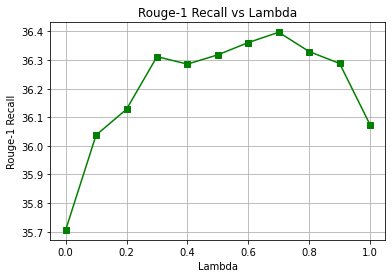

In [ ]:
import matplotlib.pyplot as plt
lam = [t/10 for t in range(11)]
rouge_recall = [r[t/10]['rouge1'][2][1]*100 for t in range(11)]
rouge_F1 = [r[t/10]['rouge1'][2][2]*100 for t in range(11)]
plt.plot(lam, rouge_recall, '-s', color='g')
plt.xlabel('Lambda')
plt.ylabel('Rouge-1 Recall')
plt.title('Rouge-1 Recall vs Lambda')
plt.grid()

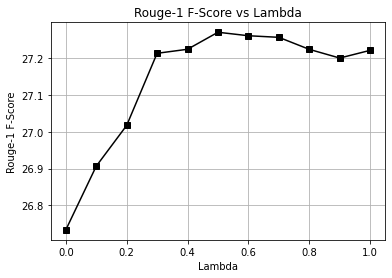

In [ ]:
plt.plot(lam, rouge_F1, '-s', color='k')
plt.xlabel('Lambda')
plt.ylabel('Rouge-1 F-Score')
plt.title('Rouge-1 F-Score vs Lambda')
plt.grid()

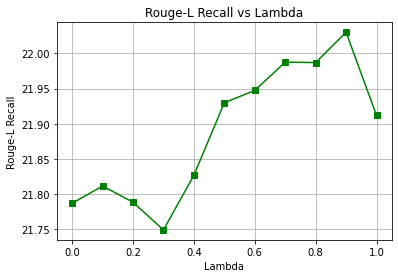

In [ ]:
import matplotlib.pyplot as plt
rouge_L_recall = [r[t/10]['rougeL'][2][1]*100 for t in range(11)]
rouge_L_F1 = [r[t/10]['rougeL'][2][2]*100 for t in range(11)]
plt.plot(lam, rouge_L_recall, '-s', color='g')
plt.xlabel('Lambda')
plt.ylabel('Rouge-L Recall')
plt.title('Rouge-L Recall vs Lambda')
plt.grid()

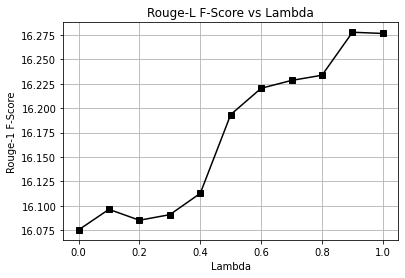

In [ ]:
plt.plot(lam, rouge_L_F1, '-s', color='k')
plt.xlabel('Lambda')
plt.ylabel('Rouge-1 F-Score')
plt.title('Rouge-L F-Score vs Lambda')
plt.grid()


In [ ]:
print(type(rouge_L_F1), max(rouge_L_F1), max(rouge_F1))

<class 'list'> 16.277848864452825 27.27137554339319


## References

[1] Few lines of code is taken from: https://github.com/sheffieldnlp/Submodular_Summ
